In [1]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

import matplotlib.pyplot as plt

# ***************************************
#
# This function calculates and observes retention rates for 2019-2023
# and then forecasts retention rates for 2023-2035
# and then uses the 2019-2035 retention rates to estimate EXEPECTED/AVG RETENTION
#
# Input Data Set to this function:
# NAFCUSTOMER_REVENUE_AGGREGATED
# Each row represents one customer per year/month
# dimensions: customer name, setup date, BI_CUS_PAR, BI_PRODUCT, BI_MRU
# measures: revenue, spend, gallons, active cards and outstanding cards
#
# **************************************
#
# The data going into this step is defined in the follopwing Input View:
#
#  CREATE VIEW DATAIKU_ANALYTICS_SUB.DATA_SCIENCE.NAFCUSTOMER_REVENUE_AGGREGATED
#  AS
#  SELECT
#  CUSTOMER_ID,
#  CUSTOMER,
#  YEAR(REVENUE_DATE) as REVENUE_YEAR,
#  MONTH(REVENUE_DATE) as REVENUE_MONTH,
#  MIN(SETUP_DATE) AS SETUP_DATE,
#  MIN(BI_CUS_PAR) as BI_CUS_PAR,
#  MIN(BI_PRODUCT) as BI_PRODUCT,
#  MIN(BI_MRU) as BI_MRU,
#  SUM(REVENUE_AMOUNT_USD) as REVENUE_AMOUNT_USD,
#  SUM(GROSS_SPEND_AMOUNT) as GROSS_SPEND_AMOUNT,
#  SUM(PURCHASE_GALLONS_QTY) PURCHASE_GALLONS_QTY,
#  SUM(TOTAL_ACTIVE_CARD_COUNT) as TOTAL_ACTIVE_CARD_COUNT
#  FROM DATAIKU_ANALYTICS_SUB.DATA_SCIENCE.NAFCUSTOMER_REVENUE
#  WHERE (FUNDED_BY IS NULL OR FUNDED_BY='Unknown' OR FUNDED_BY='WEX Funded')
#  AND (NOT((REVENUE_CODE='26') AND (CUSTOMER_ID IS NULL)))
#  AND (NOT((REVENUE_CODE='E8') AND (CUSTOMER_ID IS NULL)))
#  GROUP BY 1,2,3,4
#
# ***************************************

from datetime import date, datetime, timedelta
import time

t0 = time.time()

# Read recipe inputs
NAFCUSTOMER_REVENUE_AGGREGATED = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED")
NAFCUSTOMER_REVENUE_AGGREGATED_df = NAFCUSTOMER_REVENUE_AGGREGATED.get_dataframe()

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df))
NAFCUSTOMER_REVENUE_AGGREGATED_df.head()

load duration 6.088521635532379 minutes
18075044


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT
0,77244476.0,GATORS LAWN LANDSCAPING SVC,2021,11,2017-03-31 07:00:00+00:00,51200.0,15308.0,4120.0,0.000000,0.00,0.0000,0.0
1,77532829.0,SIECK WHOLESALE FLORIST,2021,10,2001-08-22 07:00:00+00:00,51000.0,10100.0,3100.0,371.760000,7747.75,2319.4830,14.0
2,77385040.0,MAYWOOD CHURCH OF CHRIST,2019,4,2010-10-14 07:00:00+00:00,13000.0,15100.0,4000.0,21.290000,108.90,31.7740,1.0
3,77561771.0,SUN ON FOOD CO LTD,2021,8,2011-11-11 08:00:00+00:00,20800.0,15100.0,4000.0,22.630000,2285.22,573.8035,4.0
4,77308677.0,JAKE KAUFFMAN SON INC,2021,1,2011-12-01 08:00:00+00:00,30400.0,15308.0,4120.0,1.304844,40.05,17.2020,1.0


In [2]:
# create a copy of the input dataset
# this leaves the original dataset in memory and allows for a quick reload without having to back to Snowflake

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df), "rows in NAFCUSTOMER_REVENUE_AGGREGATED")
df = NAFCUSTOMER_REVENUE_AGGREGATED_df.copy()

18075044 rows in NAFCUSTOMER_REVENUE_AGGREGATED


In [3]:
# Prep data
#
# cast year to integer and create a revenue date column using month and year
#

df['CUSTOMER_ID'] = df['CUSTOMER_ID'].astype('Int64')
df['SETUP_DATE_DT'] = pd.to_datetime(df['SETUP_DATE'])
df['SETUP_YEAR'] = df.SETUP_DATE_DT.dt.year

df['REVENUE_YEAR'] = df['REVENUE_YEAR'].astype('Int64')
df['REVENUE_DATE'] = df['REVENUE_MONTH'].astype(str) + '-' + df['REVENUE_YEAR'].astype(str)
df['REVENUE_DATE'] = pd.to_datetime(df['REVENUE_DATE'], format='%m-%Y').dt.strftime('%m-%Y')

#
# filter out Jan 2023 as it represents only a partial year
#

print(len(df), "before filter")
df = df[df.REVENUE_YEAR!=2023]
print(len(df), "after filter, removing 2023")

# break down of revenue_year
df.REVENUE_YEAR.value_counts()

18075044 before filter
17673397 after filter, removing 2023


2022    4836440
2021    4517640
2020    4243565
2019    4075752
Name: REVENUE_YEAR, dtype: Int64

NameError: name 'FuncFormatter' is not defined

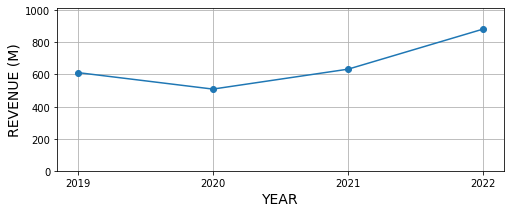

In [4]:
import matplotlib.dates as mdates

# plot out sum of revenue per year
# in order to do a quick reonciliation against 

# aggregate revenue at annual grain
df_revenue_per_year = df.groupby(['REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
df_revenue_per_year.REVENUE_AMOUNT_USD = df_revenue_per_year.REVENUE_AMOUNT_USD/1000000
df_revenue_per_year.head()

max_revenue = df_revenue_per_year.REVENUE_AMOUNT_USD.max()

chart_revenue_year = [] 
for y in df_revenue_per_year.REVENUE_YEAR.tolist():
    chart_revenue_year.append(str(y))
    
fig, ax1 = plt.subplots(figsize=(8,3))
ax1.plot(chart_revenue_year,df_revenue_per_year['REVENUE_AMOUNT_USD'], marker='o')
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('REVENUE (M)', fontsize=14)
ax1.grid()
ax1.set_ylim(ymin=0, ymax=max_revenue*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
fig.autofmt_xdate()
#ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.show()

df_revenue_per_year.head()